In [ ]:
import kagglehub
allandclive_chicken_disease_1_path = kagglehub.dataset_download('allandclive/chicken-disease-1')


print("Path to dataset files:", allandclive_chicken_disease_1_path)

Path to dataset files: /kaggle/input/chicken-disease-1


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2


In [ ]:
sdir=r'/kaggle/input/chicken-disease-1/Train'
csvpath=r'/kaggle/input/chicken-disease-1/train_data.csv'
df=pd.read_csv(csvpath)


In [ ]:
df.head()

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


In [ ]:
df.columns=['filepaths', 'labels' ]
df.head()

,filepaths,labels
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8067 entries, 0 to 8066
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  8067 non-null   object
 1   labels     8067 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB


In [ ]:
labels = df['labels'].unique()
for label in labels:
    os.makedirs(f'dataset/{label}', exist_ok=True)

# 3. Pindahkan gambar
source_folder = sdir
for idx, row in df.iterrows():
    filename = row['filepaths']
    label = row['labels']
    src_path = os.path.join(source_folder, filename)
    dst_path = os.path.join('dataset', label, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"File {filename} tidak ditemukan di {source_folder}")

new_path = '/content/dataset'

In [ ]:

# Buat folder baru untuk dataset yang sudah dibagi
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk membuat folder jika belum ada
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

make_dir(train_dir)
make_dir(val_dir)
make_dir(test_dir)

# Ambil semua kelas (nama folder)
class_names = [d for d in os.listdir(new_path) if os.path.isdir(os.path.join(new_path, d))]

# Buat folder kelas di train, val, test
for cls in class_names:
    make_dir(os.path.join(train_dir, cls))
    make_dir(os.path.join(val_dir, cls))
    make_dir(os.path.join(test_dir, cls))

# Kumpulkan semua file gambar dan labelnya
file_paths = []
labels = []

for cls in class_names:
    cls_folder = os.path.join(new_path, cls)
    files = os.listdir(cls_folder)
    for f in files:
        file_paths.append(os.path.join(cls_folder, f))
        labels.append(cls)

# Bagi dataset menjadi train dan temp
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Bagi temp menjadi validation dan test
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Fungsi untuk copy file ke folder tujuan
def copy_files(file_list, label_list, target_dir):
    for file_path, label in zip(file_list, label_list):
        dest_dir = os.path.join(target_dir, label)
        shutil.copy(file_path, dest_dir)

# Copy file ke folder train, val, test
copy_files(train_files, train_labels, train_dir)
copy_files(val_files, val_labels, val_dir)
copy_files(test_files, test_labels, test_dir)

print("Pembagian dataset selesai.")
print(f"Train set: {len(train_files)} gambar")
print(f"Validation set: {len(val_files)} gambar")
print(f"Test set: {len(test_files)} gambar")

Pembagian dataset selesai.
Train set: 5646 gambar
Validation set: 1210 gambar
Test set: 1211 gambar


In [ ]:
# 5. Data Augmentation dan Data Generator
img_size = 180
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5646 images belonging to 4 classes.
Found 1210 images belonging to 4 classes.
Found 1211 images belonging to 4 classes.


In [ ]:
model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

# --- 7. Freeze Layer dan Tambahkan Layer Baru ---
for layer in model.layers:
    if layer.name == 'block_11_add':
        break
    layer.trainable = False

inp = model.input
m = model.output
m = Flatten()(m)
m = Dense(128, activation='relu')(m)  # Increased units
m = BatchNormalization()(m)
m = Dropout(0.2)(m)  # Increased dropout rate
predict = Dense(4, activation='softmax')(m)

model_new = Model(inputs=model.input, outputs=predict)
model_new.summary()

<ipython-input-10-858f823fc934>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 90, 90, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 90, 90, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 90, 90, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 90, 90, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 90, 90, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 90, 90, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 91, 91, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 45, 45, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 8,157,380 (31.12 MB)

 Trainable params: 7,698,756 (29.37 MB)

 Non-trainable params: 458,624 (1.75 MB)

In [ ]:
from keras.optimizers import Adam

opt = Adam(0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model_new.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

callbacks = [early_stopping, model_checkpoint, lr_scheduler]

In [ ]:
epochs = 30

history = model_new.fit(
    train_generator,
    validation_data=(val_generator),
    epochs=epochs,
    verbose=1,
    callbacks= callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7123 - loss: 0.8574 - precision: 0.7414 - recall: 0.6747

177/177 ━━━━━━━━━━━━━━━━━━━━ 97s 407ms/step - accuracy: 0.7127 - loss: 0.8562 - precision: 0.7418 - recall: 0.6752 - val_accuracy: 0.7405 - val_loss: 1.3591 - val_precision: 0.7431 - val_recall: 0.7364 - learning_rate: 1.0000e-04
Epoch 2/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8496 - loss: 0.4450 - precision: 0.8686 - recall: 0.8279

177/177 ━━━━━━━━━━━━━━━━━━━━ 113s 313ms/step - accuracy: 0.8497 - loss: 0.4448 - precision: 0.8686 - recall: 0.8279 - val_accuracy: 0.7165 - val_loss: 1.3525 - val_precision: 0.7177 - val_recall: 0.7165 - learning_rate: 1.0000e-04
Epoch 3/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8681 - loss: 0.3681 - precision: 0.8869 - recall: 0.8489

177/177 ━━━━━━━━━━━━━━━━━━━━ 56s 313ms/step - accuracy: 0.8681 - loss: 0.3681 - precision: 0.8869 - recall: 0.8489 - val_accuracy: 0.8190 - val_loss: 0.6236 - val_precision: 0.8220 - val_recall: 0.8165 - learning_rate: 1.0000e-04
Epoch 4/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8971 - loss: 0.2824 - precision: 0.9142 - recall: 0.8866

177/177 ━━━━━━━━━━━━━━━━━━━━ 55s 313ms/step - accuracy: 0.8971 - loss: 0.2824 - precision: 0.9142 - recall: 0.8866 - val_accuracy: 0.8372 - val_loss: 0.6139 - val_precision: 0.8380 - val_recall: 0.8339 - learning_rate: 1.0000e-04
Epoch 5/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9092 - loss: 0.2568 - precision: 0.9225 - recall: 0.8977

177/177 ━━━━━━━━━━━━━━━━━━━━ 81s 309ms/step - accuracy: 0.9092 - loss: 0.2568 - precision: 0.9225 - recall: 0.8977 - val_accuracy: 0.8438 - val_loss: 0.5989 - val_precision: 0.8439 - val_recall: 0.8397 - learning_rate: 1.0000e-04
Epoch 6/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9163 - loss: 0.2406 - precision: 0.9282 - recall: 0.9065

177/177 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.9163 - loss: 0.2406 - precision: 0.9282 - recall: 0.9065 - val_accuracy: 0.8851 - val_loss: 0.3938 - val_precision: 0.8878 - val_recall: 0.8826 - learning_rate: 1.0000e-04
Epoch 7/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 82s 311ms/step - accuracy: 0.9153 - loss: 0.2350 - precision: 0.9242 - recall: 0.9061 - val_accuracy: 0.8851 - val_loss: 0.4760 - val_precision: 0.8865 - val_recall: 0.8843 - learning_rate: 1.0000e-04
Epoch 8/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9299 - loss: 0.1994 - precision: 0.9382 - recall: 0.9207

177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 302ms/step - accuracy: 0.9299 - loss: 0.1994 - precision: 0.9382 - recall: 0.9207 - val_accuracy: 0.9091 - val_loss: 0.3373 - val_precision: 0.9098 - val_recall: 0.9091 - learning_rate: 1.0000e-04
Epoch 9/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 53s 297ms/step - accuracy: 0.9320 - loss: 0.2137 - precision: 0.9387 - recall: 0.9215 - val_accuracy: 0.8860 - val_loss: 0.3683 - val_precision: 0.8888 - val_recall: 0.8851 - learning_rate: 1.0000e-04
Epoch 10/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9344 - loss: 0.1898 - precision: 0.9411 - recall: 0.9244

177/177 ━━━━━━━━━━━━━━━━━━━━ 84s 308ms/step - accuracy: 0.9344 - loss: 0.1897 - precision: 0.9411 - recall: 0.9245 - val_accuracy: 0.9174 - val_loss: 0.2487 - val_precision: 0.9217 - val_recall: 0.9149 - learning_rate: 1.0000e-04
Epoch 11/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9377 - loss: 0.1814 - precision: 0.9433 - recall: 0.9319

177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - accuracy: 0.9377 - loss: 0.1814 - precision: 0.9433 - recall: 0.9319 - val_accuracy: 0.9231 - val_loss: 0.2298 - val_precision: 0.9254 - val_recall: 0.9223 - learning_rate: 1.0000e-04
Epoch 12/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 53s 299ms/step - accuracy: 0.9471 - loss: 0.1473 - precision: 0.9556 - recall: 0.9413 - val_accuracy: 0.9215 - val_loss: 0.2352 - val_precision: 0.9221 - val_recall: 0.9198 - learning_rate: 1.0000e-04
Epoch 13/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9395 - loss: 0.1681 - precision: 0.9465 - recall: 0.9329

177/177 ━━━━━━━━━━━━━━━━━━━━ 55s 312ms/step - accuracy: 0.9395 - loss: 0.1681 - precision: 0.9465 - recall: 0.9329 - val_accuracy: 0.9314 - val_loss: 0.2203 - val_precision: 0.9320 - val_recall: 0.9281 - learning_rate: 1.0000e-04
Epoch 14/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9454 - loss: 0.1542 - precision: 0.9516 - recall: 0.9393

177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 306ms/step - accuracy: 0.9454 - loss: 0.1542 - precision: 0.9516 - recall: 0.9393 - val_accuracy: 0.9388 - val_loss: 0.1837 - val_precision: 0.9427 - val_recall: 0.9380 - learning_rate: 1.0000e-04
Epoch 15/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9480 - loss: 0.1444 - precision: 0.9539 - recall: 0.9460

177/177 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.9480 - loss: 0.1444 - precision: 0.9539 - recall: 0.9460 - val_accuracy: 0.9322 - val_loss: 0.1794 - val_precision: 0.9361 - val_recall: 0.9322 - learning_rate: 1.0000e-04
Epoch 16/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 304ms/step - accuracy: 0.9425 - loss: 0.1692 - precision: 0.9493 - recall: 0.9363 - val_accuracy: 0.9273 - val_loss: 0.2094 - val_precision: 0.9294 - val_recall: 0.9248 - learning_rate: 1.0000e-04
Epoch 17/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9566 - loss: 0.1336 - precision: 0.9602 - recall: 0.9530

177/177 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.9565 - loss: 0.1336 - precision: 0.9601 - recall: 0.9530 - val_accuracy: 0.9421 - val_loss: 0.1745 - val_precision: 0.9451 - val_recall: 0.9388 - learning_rate: 1.0000e-04
Epoch 18/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 305ms/step - accuracy: 0.9549 - loss: 0.1435 - precision: 0.9587 - recall: 0.9505 - val_accuracy: 0.9264 - val_loss: 0.1982 - val_precision: 0.9302 - val_recall: 0.9248 - learning_rate: 1.0000e-04
Epoch 19/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 55s 309ms/step - accuracy: 0.9548 - loss: 0.1296 - precision: 0.9598 - recall: 0.9500 - val_accuracy: 0.9281 - val_loss: 0.1902 - val_precision: 0.9302 - val_recall: 0.9248 - learning_rate: 1.0000e-04
Epoch 20/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9534 - loss: 0.1278 - precision: 0.9589 - recall: 0.9491
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
177/177 ━━━━━━━━━━━━━━━━━━━━ 53s 301ms/step - accuracy: 0.9534 - loss: 0.1279 - pre

In [ ]:
from keras.models import load_model

model = load_model('/content/best_model.h5')

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")
print(f"Test precision: {test_precision*100:.2f}%")
print(f"Test recall: {test_recall*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9715 - loss: 0.0884 - precision: 0.9736 - recall: 0.9707
Test accuracy: 95.13%
Test precision: 95.35%
Test recall: 94.88%


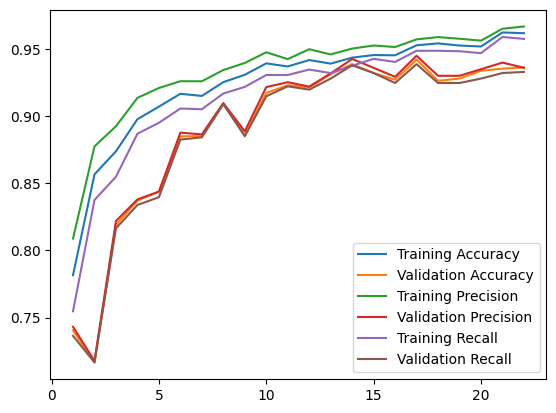

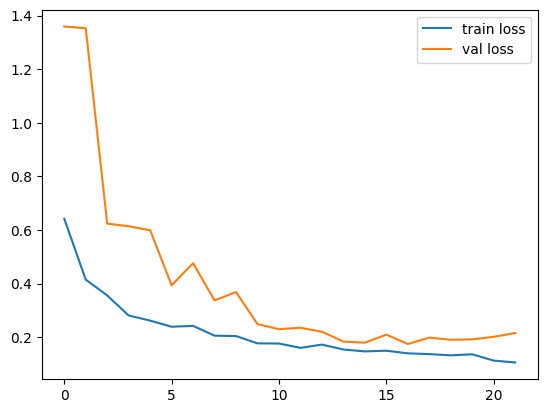

In [ ]:
import matplotlib.pyplot as plt

# Mengambil data akurasi, presisi, dan recall dari history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision  = history.history['val_precision']
train_recall = history.history['recall']
val_recall  = history.history['val_recall']

# Mengambil data langkah (step)
steps = range(1, len(train_accuracy) + 1)

# Plotting grafik akurasi, presisi, dan recall pada setiap langkah
plt.plot(steps, train_accuracy, label='Training Accuracy')
plt.plot(steps, val_accuracy, label='Validation Accuracy')

plt.plot(steps, train_precision, label='Training Precision')
plt.plot(steps, val_precision, label='Validation Precision')

plt.plot(steps, train_recall, label='Training Recall')
plt.plot(steps, val_recall, label='Validation Recall')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step
Confusion Matrix:
[[363   7   0   2]
 [  4 352   3   2]
 [  7  10  67   0]
 [  1  20   3 370]]


Text(77.92222222222226, 0.5, 'True Label')

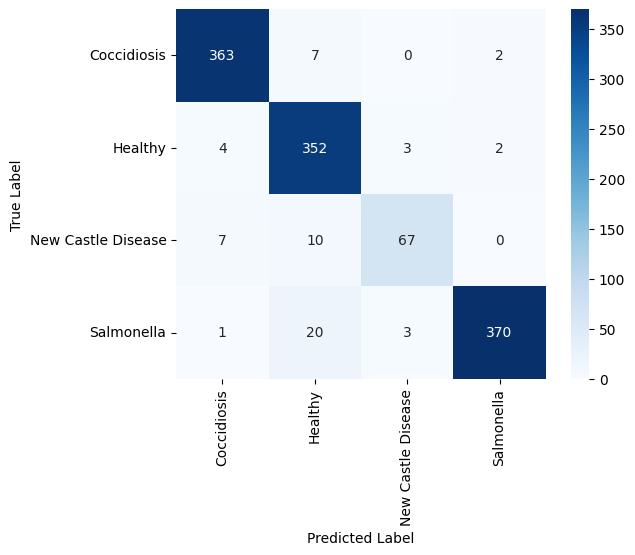

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

label_names = list(test_generator.class_indices.keys())

# make predictions on test data
test_predictions = model.predict(test_generator)

# convert predictions from one-hot encoding to class labels
test_labels = np.argmax(test_predictions, axis=1)

# get true labels of test data
true_labels = test_generator.classes

# compute confusion matrix
cm = confusion_matrix(true_labels, test_labels)

# display confusion matrix
print('Confusion Matrix:')
print(cm)

sns.heatmap(cm ,annot=True, cmap= "Blues", fmt="d", square=True,
            xticklabels=label_names, yticklabels=label_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")